# Very simple Bayesian linear regression

Using Bayesflow to do ABI for a simple bayesian linear regression with Gaussian priors for a single intercept and slope.

In [2]:
import numpy as np
import bayesflow as bf
import matplotlib.pyplot as plt

/Users/lasse/miniconda3/envs/bayesflow/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Suppose we have a simple linear regression model with a single predictor variable $x$ and a single response variable $y$. The model is defined as follows:

(priors)
$$ \alpha \sim \mathcal{N}(0, 1) $$
$$ \beta \sim \mathcal{N}(0, 1) $$
(likelihood)
$$ x \sim \mathcal{N}(0, 1) $$
$$ y \sim \mathcal{N}(\alpha + \beta x, 1) $$




In [3]:
seed = 2024
RNG = np.random.default_rng(seed)

Defining the prior

In [4]:
def prior_func():
    alpha = RNG.normal()
    beta = RNG.normal()
    return np.r_[alpha, beta]

prior_func()

array([1.02885687, 1.64192004])

In [5]:
prior = bf.simulation.Prior(prior_fun=prior_func, param_names=['alpha', 'beta'])

In [6]:
prior(batch_size=3)

{'prior_draws': array([[ 1.14671953, -0.97317952],
        [-1.3928001 ,  0.06719636],
        [ 0.86135092,  0.5091868 ]]),
 'batchable_context': None,
 'non_batchable_context': None}

Visualizing the prior

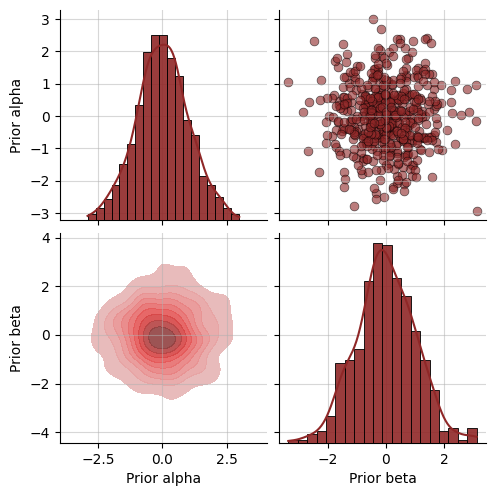

In [7]:
f = prior.plot_prior2d(n_samples=500)

In [8]:
def likelihood_func(params, n_obs = 100):
    alpha, beta = params
    x = np.random.normal(size=n_obs)
    mean = alpha + beta * x
    y = np.random.normal(loc=mean, size = n_obs)
    return np.column_stack([x, y]) # (n_obs, params.shape[0])

simulator = bf.simulation.Simulator(simulator_fun=likelihood_func)

In [9]:
likelihood_func([0,0], n_obs=10).shape

(10, 2)

In [10]:
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [11]:
out = model(batch_size = 5)
out["sim_data"].shape

(5, 100, 2)

In [12]:
# quick prior predictive check on outcomes
y = out["sim_data"][:,:,1]
y.shape

(5, 100)

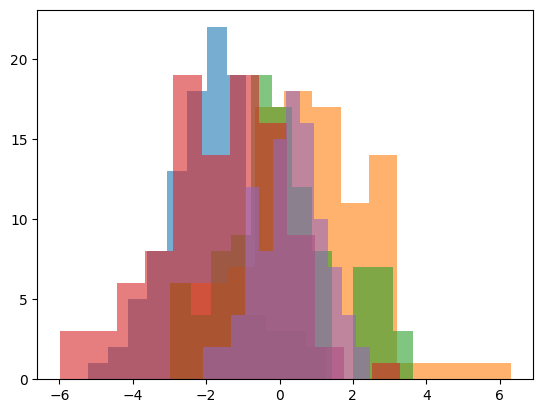

In [13]:
# plot distribution of y from each batch
for a in range(y.shape[0]):
    plt.hist(y[a,:], bins=12, alpha=0.6)

In [14]:
summary_net = bf.networks.DeepSet(summary_dim=6)
inference_net = bf.networks.InvertibleNetwork(num_params=2, num_coupling_layers=3,
                                              coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False}, # no L2 and no dropout regularization since online simulation
)                                

Examples of the summary statistics for 3 batches (by the untrained summary network).

In [15]:
test_input = model(batch_size=3)
summary_rep = summary_net(test_input["sim_data"]).numpy()
summary_rep

array([[ 0.01212498, -0.01821017,  0.01641318, -0.00376891,  0.03091416,
         0.01902091],
       [ 0.00872412, -0.01620301,  0.00677703,  0.00104564,  0.02132069,
         0.01043531],
       [ 0.00957632, -0.02037034,  0.00425167,  0.00010342,  0.02392578,
         0.00993499]], dtype=float32)

Getting (untrained) latent space projections:

In [16]:
z, log_det_J = inference_net(test_input["prior_draws"], summary_rep) # (theta, summary(x))
z.numpy()

array([[-1.9573604 , -0.8658209 ],
       [-0.81282735,  0.79569495],
       [-0.8279168 ,  1.7259955 ]], dtype=float32)

z represents the latent representation of our parameters, which is constrained to be Gaussian by design:

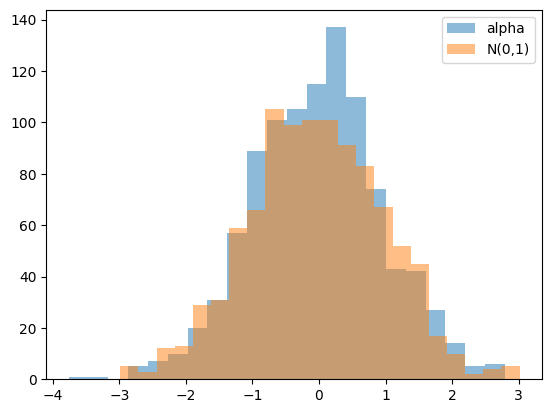

In [17]:
test_input_large = model(batch_size=1000)
summary_rep_large = summary_net(test_input_large["sim_data"]).numpy()
z_large, log_det_J_large = inference_net(test_input_large["prior_draws"], summary_rep_large) # (theta, summary(x))
# plot a histogram of both dimensions of z_large
plt.hist(z_large[:,0], bins=22, alpha=0.5, label="alpha")
# simulate normal distribution with mean 0 and std 1
x = np.random.normal(0, 1, 1000)
plt.hist(x, bins=22, alpha=0.5, label="N(0,1)")
plt.legend()
plt.show()

In [18]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Since our data is readily useable for a NN, I do not need to set a manual configurator.

In [19]:
%%time
history = trainer.train_online(epochs=10, iterations_per_epoch=1000, batch_size=64, validation_sims=200)

INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 1000/1000 [00:26<00:00, 37.64it/s, Epoch: 1, Iter: 1000,Loss: -0.710,Avg.Loss: 0.144,LR: 4.88E-04]
INFO:root:Validation, Epoch: 1, Loss: -1.084
Training epoch 2: 100%|██████████| 1000/1000 [00:26<00:00, 37.92it/s, Epoch: 2, Iter: 1000,Loss: -1.222,Avg.Loss: -1.225,LR: 4.52E-04]
INFO:root:Validation, Epoch: 2, Loss: -1.517
Training epoch 3: 100%|██████████| 1000/1000 [00:28<00:00, 35.16it/s, Epoch: 3, Iter: 1000,Loss: -1.305,Avg.Loss: -1.378,LR: 3.97E-04]
INFO:root:Validation, Epoch: 3, Loss: -1.455
Training epoch 4: 100%|██████████| 1000/1000 [00:30<00:00, 33.08it/s, Epoch: 4, Iter: 1000,Loss: -1.549,Avg.Loss: -1.475,LR: 3.27E-04]
INFO:root:Validation, Epoch: 4, Loss: -1.574
Training epoch 5: 100%|██████████| 1000/1000 [00:31<00:00, 32.22it/s, Epoch: 5, Iter: 1000,Loss: -1.509,Avg.Loss: -1.532,LR: 2.50E-04]
INFO:root:Validation, Epoch: 5, Loss: -1.574
Training epoch 6: 100%|██████████| 1000/1000 [00:

CPU times: user 8min 1s, sys: 4min 21s, total: 12min 23s
Wall time: 4min 33s


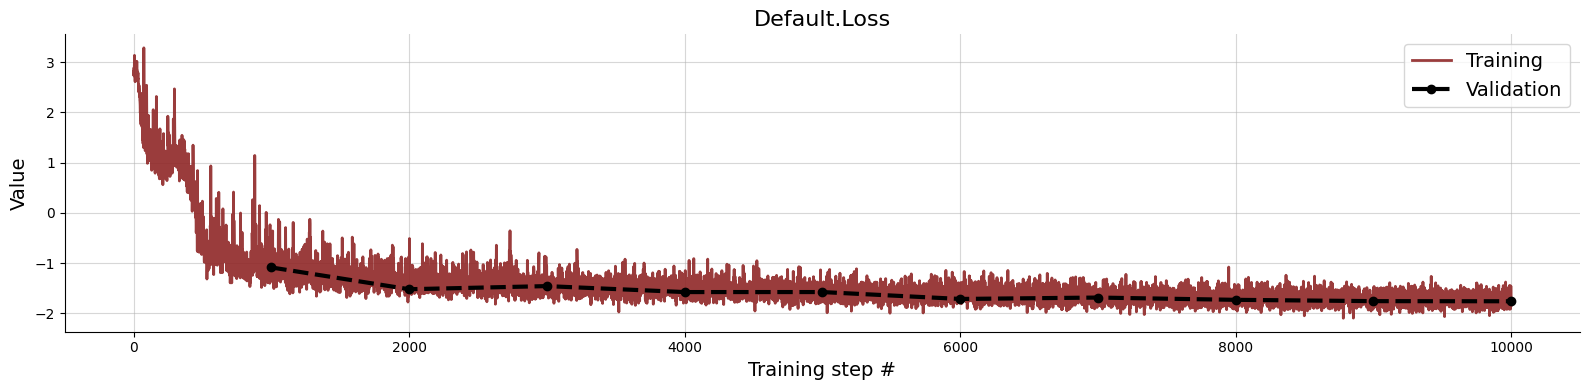

In [20]:
f = bf.diagnostics.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)

In [21]:
test_sims = trainer.configurator(model(200)) # generate 200 unseen data sets
list(test_sims.keys())

['summary_conditions', 'direct_conditions', 'parameters']

In [22]:
posterior_samples = amortizer.sample(test_sims, n_samples=100)
posterior_samples.shape

(200, 100, 2)

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 2.                    Confidence intervals might be unreliable!


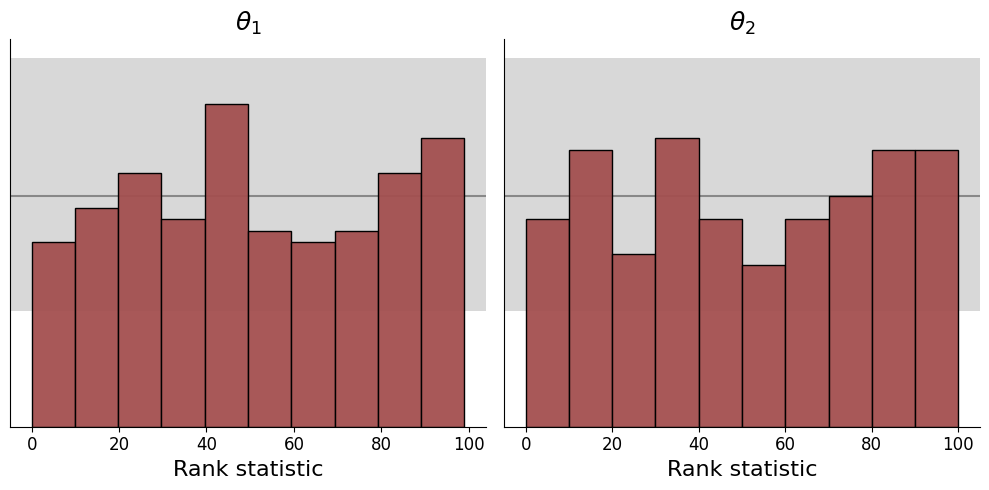

In [23]:
f = bf.diagnostics.plot_sbc_histograms(posterior_samples, test_sims["parameters"], num_bins = 10)

we take those

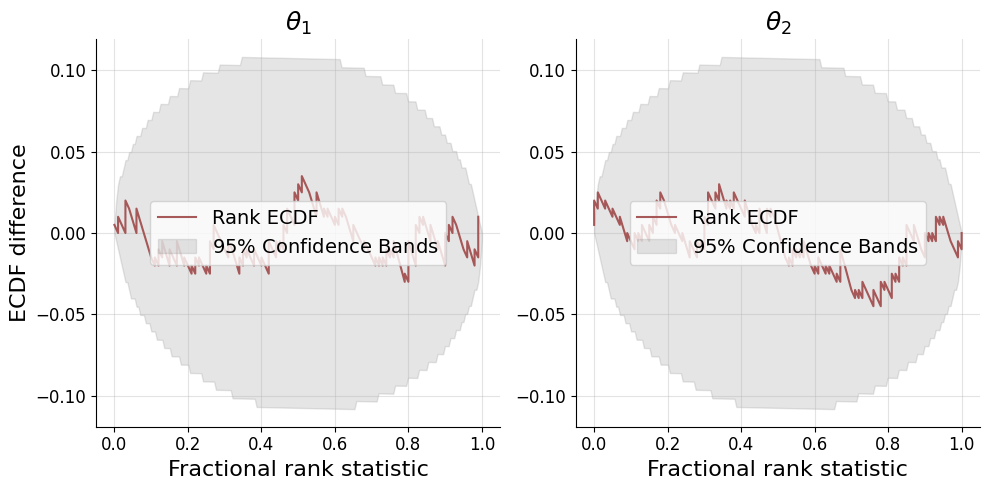

In [24]:
# plotting difference between posterior samples and true parameters
f = bf.diagnostics.plot_sbc_ecdf(posterior_samples, test_sims["parameters"], difference=True)

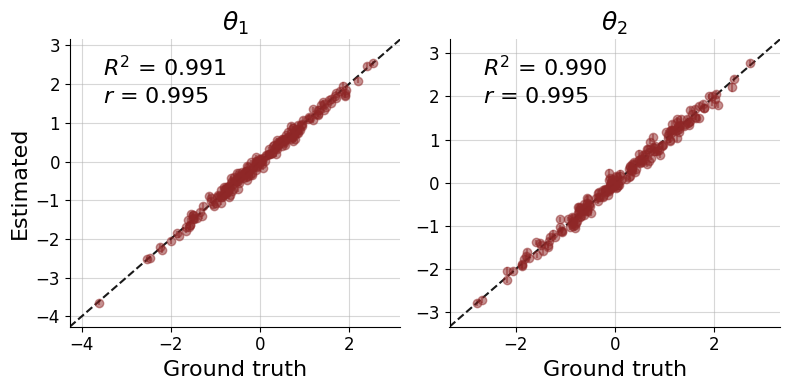

In [25]:
f = bf.diagnostics.plot_recovery(posterior_samples, test_sims["parameters"])

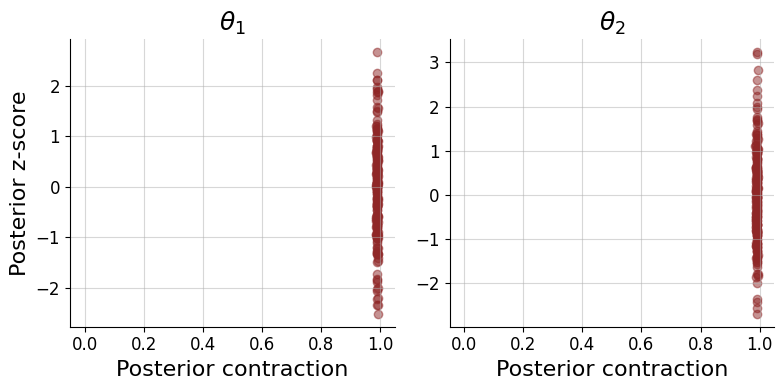

In [26]:
f = bf.diagnostics.plot_z_score_contraction(posterior_samples, test_sims["parameters"])

Great diagnostics!

Let's "demo" how we could do inference for a given observed set of data now in practice.

In [28]:
data = model(1)
data["prior_draws"]

array([[ 1.68087315, -0.58239054]])

In [35]:
data_in = data["sim_data"]
data_in.shape

(1, 100, 2)

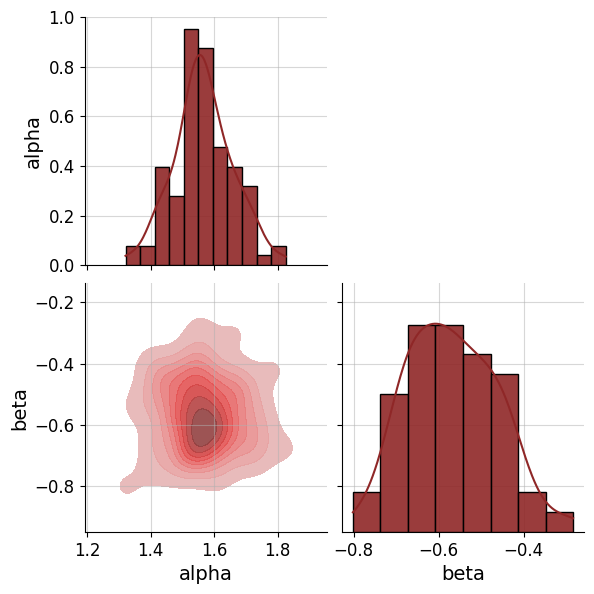

In [41]:
# I want to get posterior draws for this data
data_out = amortizer.sample({"summary_conditions": data_in}, n_samples=100)
f = bf.diagnostics.plot_posterior_2d(data_out, param_names=['alpha', 'beta'])

With 100 data points for x and y, the model puts the posterior peaks directly on the true generative values. What is we observe only 5 data points?

In [42]:
data_in_5 = data_in[:,np.random.choice(data_in.shape[1], 5, replace=False),:]
data_in_5.shape

(1, 5, 2)

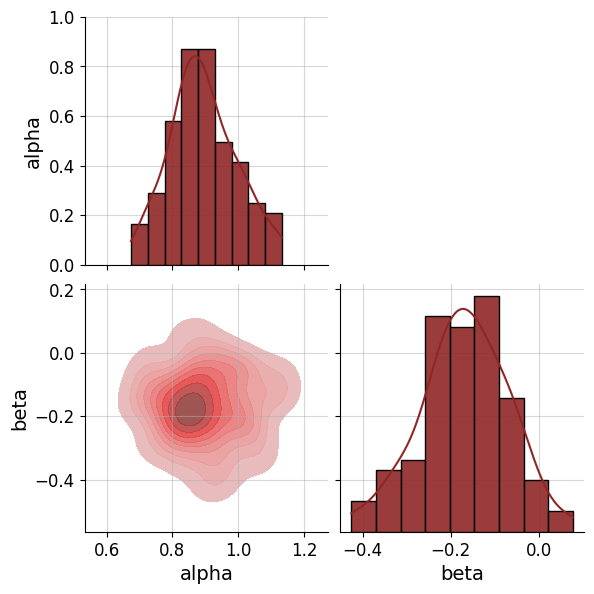

In [43]:
data_out_5 = amortizer.sample({"summary_conditions": data_in_5}, n_samples=100)
f = bf.diagnostics.plot_posterior_2d(data_out_5, param_names=['alpha', 'beta'])

As expected, both posterior distributions are wider, and shrunk further towards the prior distribution.